In [83]:
import json
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from concurrent import futures
from tqdm.notebook import tqdm
from pprint import pprint
from matplotlib import pyplot as plt
import japanize_matplotlib

from common import weight_add_result, QrelDataLoader, weight_add_result_org
from beir.retrieval.evaluation import EvaluateRetrieval

In [2]:
def load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root):
    data_dir = os.path.join(data_dir_root, dataset)
    queries, qrels = QrelDataLoader(data_folder=data_dir).load(split="test")
    
    bm25_result_path = os.path.join(result_dir_root, dataset, "result/bm25/analysis.json")
    dense_result_path = os.path.join(result_dir_root, dataset, "result/dot/mpnet-v3-mse-beir-dot/analysis.json")

    with open(bm25_result_path) as f:
        bm25_result = json.load(f)
    
    with open(dense_result_path) as f:
         dense_result = json.load(f)
            
    all_qids = qrels.keys()
    return (all_qids, qrels, bm25_result, dense_result)

def load_dataset_and_splade_result(dataset, data_dir_root, result_dir_root):
    data_dir = os.path.join(data_dir_root, dataset)
    queries, qrels = QrelDataLoader(data_folder=data_dir).load(split="test")
    
    splade_result_path = os.path.join(result_dir_root, dataset, "result/dot/distil-splade/analysis.json")
    
    with open(splade_result_path) as f:
         splade_result = json.load(f)
            
    all_qids = qrels.keys()
    return (all_qids, qrels, splade_result)

def weight_add_result_per_dataset(weight, all_qids, qrels, bm25_result, dense_result):
    # k_values = [1, 10, 100]
    k_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    results = weight_add_result(bm25_result, dense_result, all_qids, weight)
    ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(qrels, results, k_values=k_values)
    # return ndcg["NDCG@10"]
    return ndcg

def weight_add_result_per_dataset_wrcap(weight, all_qids, qrels, bm25_result, dense_result):
    # k_values = [1, 10, 100]
    k_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    results = weight_add_result(bm25_result, dense_result, all_qids, weight)
    ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(qrels, results, k_values=k_values)
    rcap = EvaluateRetrieval("").evaluate_custom(qrels, results, k_values, metric="r_cap")
    return {"ndcg": ndcg, "recall": recall, "rcap": rcap}

def weight_add_org_result_per_dataset(weight,qrels, bm25_result, dense_result):
    # k_values = [1, 10, 100]
    k_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    results = weight_add_result_org(qrels, dense_result, bm25_result, weight)
    ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(qrels, results, k_values=k_values)
    # return ndcg["NDCG@10"]
    return ndcg

In [3]:
def load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root):
    data_dir = os.path.join(data_dir_root, dataset)
    queries, qrels = QrelDataLoader(data_folder=data_dir).load(split="test")
    cbm25_result_path = os.path.join(result_dir_root, dataset, "result/lss/mpnet-tod/analysis.json")
    dense_result_path = os.path.join(result_dir_root, dataset, "result/dot/mpnet-v3-mse-beir-dot/analysis.json")

    with open(cbm25_result_path) as f:
        cbm25_result = list(json.load(f).values())[0]
    
    with open(dense_result_path) as f:
        dense_result = json.load(f)
            
    all_qids = qrels.keys()
    return (all_qids, qrels, cbm25_result, dense_result)

In [4]:
datasets = ["arguana", "climate-fever", "dbpedia-entity", "fever", "fiqa", "hotpotqa", "msmarco", "nfcorpus", "nq",
      "quora", "scidocs", "scifact", "trec-covid", "trec-robust04-title", "trec-robust04-desc", "webis-touche2020"]

data_dir_root = "/home/gaia_data/iida.h/BEIR/datasets/"
result_dir_root = "/home/gaia_data/iida.h/BEIR/C-BM25/results/"

In [5]:
# all_bm25_result = {}
# all_dense_result = {}
# k_values = [1, 10, 100]
# for dataset in tqdm(datasets):
#     all_qids, qrels, bm25_result, dense_result = load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root)
#     bm25_ndcg, _, _, _ = EvaluateRetrieval("").evaluate(qrels, bm25_result, k_values=k_values)
#     dense_ndcg, _, _, _ = EvaluateRetrieval("").evaluate(qrels, dense_result, k_values=k_values)
#     all_bm25_result[dataset] = bm25_ndcg["NDCG@10"]
#     all_dense_result[dataset] = dense_ndcg["NDCG@10"]
    
# pprint(all_bm25_result)
# pprint(all_dense_result)

In [6]:
k_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bm25_ndcg = {}
cbm25_ndcg = {}
dense_ndcg = {}
for dataset in tqdm(datasets):
    if dataset in {"msmarco", "trec-robust04-title"}:
        continue
    all_qids, qrels, bm25_result, dense_result = load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root)
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
    ndcg_bm25, map_bm25, recall_bm25, p_bm25 = EvaluateRetrieval("").evaluate(qrels, bm25_result, k_values=k_values)
    ndcg_d, map_d, recall_d, p_d = EvaluateRetrieval("").evaluate(qrels, dense_result, k_values=k_values)
    ndcg_cbm25, map_cbm25, recall_cbm25, p_cbm25 = EvaluateRetrieval("").evaluate(qrels, cbm25_result, k_values=k_values)
    bm25_ndcg[dataset] = ndcg_bm25
    cbm25_ndcg[dataset] = ndcg_cbm25
    dense_ndcg[dataset] = ndcg_d
    # bm25_ndcg[dataset] = ndcg_bm25["NDCG@10"]
    # cbm25_ndcg[dataset] = ndcg_cbm25["NDCG@10"]
    # dense_ndcg[dataset] = ndcg_d["NDCG@10"]

  0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
def average_each_result_on_each_rank(results):
    prototype = defaultdict(list)
    for result in results.values():
        for k, v in result.items():
            prototype[k].append(v)
    average_results = {k: np.average(v) for k, v in prototype.items()}
    return average_results

In [8]:
print("bm25")
pprint(average_each_result_on_each_rank(bm25_ndcg))
print("cbm25")
pprint(average_each_result_on_each_rank(cbm25_ndcg))
print("dense")
pprint(average_each_result_on_each_rank(dense_ndcg))
# print("bm25: ", np.average(list(bm25_ndcg.values())))
# print("cbm25: ", np.average(list(cbm25_ndcg.values())))
# print("dense25: ", np.average(list(dense_ndcg.values())))

bm25
{'NDCG@1': 0.3957285714285715,
 'NDCG@10': 0.4102328571428572,
 'NDCG@100': 0.4344328571428571,
 'NDCG@20': 0.4147392857142857,
 'NDCG@30': 0.41938785714285715,
 'NDCG@40': 0.4227535714285714,
 'NDCG@50': 0.4253642857142857,
 'NDCG@60': 0.42771714285714285,
 'NDCG@70': 0.42982785714285715,
 'NDCG@80': 0.431725,
 'NDCG@90': 0.43306857142857147}
cbm25
{'NDCG@1': 0.4832328571428572,
 'NDCG@10': 0.4864685714285714,
 'NDCG@100': 0.4857678571428571,
 'NDCG@20': 0.48733857142857145,
 'NDCG@30': 0.48754357142857135,
 'NDCG@40': 0.48839,
 'NDCG@50': 0.48836571428571424,
 'NDCG@60': 0.48830642857142864,
 'NDCG@70': 0.4873864285714286,
 'NDCG@80': 0.4870607142857143,
 'NDCG@90': 0.4864792857142857}
dense
{'NDCG@1': 0.42644857142857145,
 'NDCG@10': 0.43979428571428575,
 'NDCG@100': 0.45929785714285715,
 'NDCG@20': 0.44646357142857146,
 'NDCG@30': 0.44864928571428564,
 'NDCG@40': 0.4511785714285715,
 'NDCG@50': 0.45264428571428583,
 'NDCG@60': 0.4540828571428571,
 'NDCG@70': 0.4556800000000001

In [9]:
weight_org_bm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, bm25_result, dense_result = load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root)
    with futures.ProcessPoolExecutor(max_workers=2) as executer:
        furs = []
        for weight in range(11):
            weight *= 0.1
            furs.append((weight, executer.submit(weight_add_org_result_per_dataset, weight, qrels, bm25_result, dense_result)))
        for weight, future in furs:
            weight_2 = round(weight, 2)
            ndcg = future.result()
            # weight_org_bm25_dense_ndcg[name][weight_2][dataset] = ndcg
            for name, value in ndcg.items():
                if weight_2 not in weight_org_bm25_dense_ndcg[name]:
                    weight_org_bm25_dense_ndcg[name][weight_2] = {}
                weight_org_bm25_dense_ndcg[name][weight_2][dataset] = value
                
print(weight_org_bm25_dense_ndcg)

  0%|          | 0/16 [00:00<?, ?it/s]

IOStream.flush timed out


defaultdict(<class 'dict'>, {'NDCG@1': {0.0: {'arguana': 0.25889, 'climate-fever': 0.19088, 'dbpedia-entity': 0.465, 'fever': 0.56961, 'fiqa': 0.30556, 'hotpotqa': 0.67995, 'msmarco': 0.75581, 'nfcorpus': 0.41022, 'nq': 0.30823, 'quora': 0.7569, 'scidocs': 0.174, 'scifact': 0.46667, 'trec-covid': 0.65, 'trec-robust04-title': 0.50803, 'trec-robust04-desc': 0.52008, 'webis-touche2020': 0.21429}, 0.1: {'arguana': 0.23826, 'climate-fever': 0.23453, 'dbpedia-entity': 0.50125, 'fever': 0.61866, 'fiqa': 0.32099, 'hotpotqa': 0.7391, 'msmarco': 0.78682, 'nfcorpus': 0.42105, 'nq': 0.32329, 'quora': 0.7769, 'scidocs': 0.183, 'scifact': 0.50667, 'trec-covid': 0.75, 'trec-robust04-title': 0.51606, 'trec-robust04-desc': 0.62048, 'webis-touche2020': 0.20408}, 0.2: {'arguana': 0.21693, 'climate-fever': 0.24104, 'dbpedia-entity': 0.50125, 'fever': 0.63801, 'fiqa': 0.33179, 'hotpotqa': 0.7684, 'msmarco': 0.77519, 'nfcorpus': 0.4226, 'nq': 0.32503, 'quora': 0.7871, 'scidocs': 0.188, 'scifact': 0.53333, '

In [10]:
with open("weight_sum_results/bm25_dense_ndcg_each_dataset_org_deeper_k.json", "w") as f:
    json.dump(weight_org_bm25_dense_ndcg, f)

In [11]:
all_weight_org_bm25_dense_ndcg = defaultdict(dict)
for k, weight_ndcgs in weight_org_bm25_dense_ndcg.items():
    for weight, ndcgs in weight_ndcgs.items():
        ndcgs = [value for key, value in ndcgs.items() if key not in {"msmarco", "trec-robust04-title"}]
        all_weight_org_bm25_dense_ndcg[k][weight] = np.round(np.mean(ndcgs), 4)
    
pprint(all_weight_org_bm25_dense_ndcg)

defaultdict(<class 'dict'>,
            {'NDCG@1': {0.0: 0.4264,
                        0.1: 0.4599,
                        0.2: 0.475,
                        0.3: 0.4861,
                        0.4: 0.4872,
                        0.5: 0.4858,
                        0.6: 0.4836,
                        0.7: 0.4726,
                        0.8: 0.4561,
                        0.9: 0.4319,
                        1.0: 0.3942},
             'NDCG@10': {0.0: 0.4398,
                         0.1: 0.4693,
                         0.2: 0.4857,
                         0.3: 0.4957,
                         0.4: 0.4975,
                         0.5: 0.4959,
                         0.6: 0.4902,
                         0.7: 0.4827,
                         0.8: 0.4671,
                         0.9: 0.4435,
                         1.0: 0.4092},
             'NDCG@100': {0.0: 0.4593,
                          0.1: 0.4859,
                          0.2: 0.5003,
                          0.3

In [12]:
with open("weight_sum_results/bm25_dense_ndcg_ave-all_org_deeper_k.json", "w") as f:
    json.dump(all_weight_org_bm25_dense_ndcg, f)

In [13]:
weight_bm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, bm25_result, dense_result = load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root)
#     with futures.ProcessPoolExecutor(max_workers=3) as executer:
#         furs = []
#         for weight in range(11):
#             weight *= 0.1
#             furs.append((weight, executer.submit(weight_add_result_per_dataset, weight, all_qids, qrels, bm25_result, dense_result)))
#         for weight, future in furs:
#             ndcg10 = future.result()
#             weight_bm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10

    for weight in range(11):
        weight *= 0.1
        weight_2 = round(weight, 2)
        ndcg = weight_add_result_per_dataset(weight, all_qids, qrels, bm25_result, dense_result)
        # weight_bm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10
        for name, value in ndcg.items():
            if weight_2 not in weight_bm25_dense_ndcg[name]:
                weight_bm25_dense_ndcg[name][weight_2] = {}
            weight_bm25_dense_ndcg[name][weight_2][dataset] = value

pprint(weight_bm25_dense_ndcg)

  0%|          | 0/16 [00:00<?, ?it/s]

defaultdict(<class 'dict'>,
            {'NDCG@1': {0.0: {'arguana': 0.25889,
                              'climate-fever': 0.19088,
                              'dbpedia-entity': 0.465,
                              'fever': 0.56961,
                              'fiqa': 0.30556,
                              'hotpotqa': 0.67995,
                              'msmarco': 0.75581,
                              'nfcorpus': 0.41022,
                              'nq': 0.30823,
                              'quora': 0.7569,
                              'scidocs': 0.174,
                              'scifact': 0.46667,
                              'trec-covid': 0.65,
                              'trec-robust04-desc': 0.52008,
                              'trec-robust04-title': 0.50803,
                              'webis-touche2020': 0.21429},
                        0.1: {'arguana': 0.23826,
                              'climate-fever': 0.21498,
                              'dbpe

In [14]:
with open("weight_sum_results/bm25_dense_ndcg_each_dataset_deeper_k.json", "w") as f:
    json.dump(weight_bm25_dense_ndcg, f)

In [15]:
all_weight_bm25_dense_ndcg = defaultdict(dict)
for k, weight_ndcgs in weight_bm25_dense_ndcg.items():
    for weight, ndcg in weight_ndcgs.items():
        ndcgs = [value for key, value in ndcg.items() if key not in {"msmarco", "trec-robust04-title"}]
        all_weight_bm25_dense_ndcg[k][weight] = np.round(np.mean(ndcgs), 4)

pprint(all_weight_bm25_dense_ndcg)

defaultdict(<class 'dict'>,
            {'NDCG@1': {0.0: 0.4264,
                        0.1: 0.4442,
                        0.2: 0.4532,
                        0.3: 0.4654,
                        0.4: 0.4754,
                        0.5: 0.4803,
                        0.6: 0.4888,
                        0.7: 0.4751,
                        0.8: 0.457,
                        0.9: 0.4308,
                        1.0: 0.3957},
             'NDCG@10': {0.0: 0.4398,
                         0.1: 0.454,
                         0.2: 0.465,
                         0.3: 0.4751,
                         0.4: 0.4837,
                         0.5: 0.4902,
                         0.6: 0.4928,
                         0.7: 0.4883,
                         0.8: 0.4716,
                         0.9: 0.4431,
                         1.0: 0.4102},
             'NDCG@100': {0.0: 0.4593,
                          0.1: 0.4723,
                          0.2: 0.4818,
                          0.3: 

In [16]:
with open("weight_sum_results/bm25_dense_ndcg_ave-all_deeper_k.json", "w") as f:
    json.dump(all_weight_bm25_dense_ndcg, f)

In [17]:
weight_org_cbm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
    with futures.ProcessPoolExecutor(max_workers=2) as executer:
        furs = []
        for weight in range(11):
            weight *= 0.1
            furs.append((weight, executer.submit(weight_add_org_result_per_dataset, weight, qrels, cbm25_result, dense_result)))
        for weight, future in furs:
            ndcg = future.result()
            # weight_org_cbm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10        
            for name, value in ndcg.items():
                if weight_2 not in weight_org_cbm25_dense_ndcg[name]:
                    weight_org_cbm25_dense_ndcg[name][weight_2] = {}
                weight_org_cbm25_dense_ndcg[name][weight_2][dataset] = value

        
pprint(weight_org_cbm25_dense_ndcg)

  0%|          | 0/16 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out


defaultdict(<class 'dict'>,
            {'NDCG@1': {1.0: {'arguana': 0.21053,
                              'climate-fever': 0.22345,
                              'dbpedia-entity': 0.43625,
                              'fever': 0.64671,
                              'fiqa': 0.31019,
                              'hotpotqa': 0.79041,
                              'msmarco': 0.73256,
                              'nfcorpus': 0.4613,
                              'nq': 0.27926,
                              'quora': 0.7697,
                              'scidocs': 0.187,
                              'scifact': 0.58333,
                              'trec-covid': 0.84,
                              'trec-robust04-desc': 0.58835,
                              'trec-robust04-title': 0.57028,
                              'webis-touche2020': 0.43878}},
             'NDCG@10': {1.0: {'arguana': 0.44868,
                               'climate-fever': 0.24401,
                               

In [18]:
with open("weight_sum_results/cbm25_dense_ndcg_each_dataset_org_deeper_k.json", "w") as f:
    json.dump(weight_org_cbm25_dense_ndcg, f)

In [19]:
# dataset="bioask"
# all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
# weight = 0.5
# ndcg10 = weight_add_org_result_per_dataset(weight, qrels, cbm25_result, dense_result)
# ndcg10

In [20]:
all_weight_org_cbm25_dense_ndcg = defaultdict(dict)
for k, weight_ndcgs in weight_org_cbm25_dense_ndcg.items():
    for weight, ndcgs in weight_ndcgs.items():
        ndcgs = [value for key, value in ndcgs.items() if key not in {"msmarco", "trec-robust04-title"}]
        all_weight_org_cbm25_dense_ndcg[k][weight] = np.round(np.mean(ndcgs), 4)
    
pprint(all_weight_org_cbm25_dense_ndcg)

defaultdict(<class 'dict'>,
            {'NDCG@1': {1.0: 0.4832},
             'NDCG@10': {1.0: 0.4866},
             'NDCG@100': {1.0: 0.4868},
             'NDCG@20': {1.0: 0.4875},
             'NDCG@30': {1.0: 0.4878},
             'NDCG@40': {1.0: 0.4887},
             'NDCG@50': {1.0: 0.4888},
             'NDCG@60': {1.0: 0.4889},
             'NDCG@70': {1.0: 0.4881},
             'NDCG@80': {1.0: 0.4878},
             'NDCG@90': {1.0: 0.4874}})


In [21]:
with open("weight_sum_results/cbm25_dense_ndcg_ave-all_org_deeper_k.json", "w") as f:
    json.dump(all_weight_org_cbm25_dense_ndcg, f)

In [22]:
weight_cbm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
#     with futures.ProcessPoolExecutor(max_workers=3) as executer:
#         furs = []
#         for weight in range(11):
#             weight *= 0.1
#             furs.append((weight, executer.submit(add_result_per_dataset, qrels, cbm25_result, dense_result)))
#         for weight, future in furs:
#             ndcg10 = future.result()
#             weight_cbm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10
    for weight in range(11):
        weight *= 0.1
        weight_2 = round(weight, 2)
        ndcg = weight_add_result_per_dataset(weight, all_qids, qrels, cbm25_result, dense_result)
        # weight_cbm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10
        for name, value in ndcg.items():
            if weight_2 not in weight_cbm25_dense_ndcg[name]:
                weight_cbm25_dense_ndcg[name][weight_2] = {}
            weight_cbm25_dense_ndcg[name][weight_2][dataset] = value


pprint(weight_cbm25_dense_ndcg)

  0%|          | 0/16 [00:00<?, ?it/s]

defaultdict(<class 'dict'>,
            {'NDCG@1': {0.0: {'arguana': 0.25889,
                              'climate-fever': 0.19088,
                              'dbpedia-entity': 0.465,
                              'fever': 0.56961,
                              'fiqa': 0.30556,
                              'hotpotqa': 0.67995,
                              'msmarco': 0.75581,
                              'nfcorpus': 0.41022,
                              'nq': 0.30823,
                              'quora': 0.7569,
                              'scidocs': 0.174,
                              'scifact': 0.46667,
                              'trec-covid': 0.65,
                              'trec-robust04-desc': 0.52008,
                              'trec-robust04-title': 0.50803,
                              'webis-touche2020': 0.21429},
                        0.1: {'arguana': 0.24467,
                              'climate-fever': 0.23713,
                              'dbpe

In [23]:
with open("weight_sum_results/cbm25_dense_ndcg_each_dataset_deeper_k.json", "w") as f:
    json.dump(weight_cbm25_dense_ndcg, f)

In [24]:
# datasets=["bioask", "nfcorpus", "trec-covid", "scidocs", "scifact"]
# all_result = {}
# for dataset in datasets:
#     all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
#     weight = 0.5
#     result = weight_add_result_per_dataset_wrcap(weight, all_qids, qrels, cbm25_result, dense_result)
#     all_result[dataset] = result
# pprint(all_result)

In [25]:
# weight_cbm25_dense_ndcg = defaultdict(dict)
# datasets = ["arguana", "climate-fever", "dbpedia-entity", "fever", "fiqa", "hotpotqa", "msmarco", "nfcorpus", "nq",
#       "quora", "scidocs", "scifact", "trec-covid", "trec-robust04-title", "trec-robust04-desc", "webis-touche2020"]

# data_dir_root = "/home/gaia_data/iida.h/BEIR/datasets/"
# result_dir_root = "/home/gaia_data/iida.h/BEIR/C-BM25/results/"
# for dataset in tqdm(datasets):
#     print(dataset)
#     all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
#     for weight in range(11):
#         weight *= 0.1
#         ndcg10 = weight_add_result_per_dataset(weight, all_qids, qrels, cbm25_result, dense_result)
#         weight_cbm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10
            
# pprint(weight_cbm25_dense_ndcg)

In [26]:
all_weight_cbm25_dense_ndcg = defaultdict(dict)
for k, weight_ndcgs in weight_cbm25_dense_ndcg.items():
    for weight, ndcgs in weight_ndcgs.items():
        ndcgs = [value for key, value in ndcgs.items() if key not in {"msmarco", "trec-robust04-title"}]
        all_weight_cbm25_dense_ndcg[k][weight] = np.round(np.mean(ndcgs), 4)
    
pprint(all_weight_cbm25_dense_ndcg)

defaultdict(<class 'dict'>,
            {'NDCG@1': {0.0: 0.4264,
                        0.1: 0.4694,
                        0.2: 0.4847,
                        0.3: 0.491,
                        0.4: 0.4945,
                        0.5: 0.4959,
                        0.6: 0.4988,
                        0.7: 0.4948,
                        0.8: 0.4896,
                        0.9: 0.4856,
                        1.0: 0.485},
             'NDCG@10': {0.0: 0.4398,
                         0.1: 0.4764,
                         0.2: 0.4929,
                         0.3: 0.5023,
                         0.4: 0.5066,
                         0.5: 0.5052,
                         0.6: 0.502,
                         0.7: 0.4988,
                         0.8: 0.4954,
                         0.9: 0.4914,
                         1.0: 0.4877},
             'NDCG@100': {0.0: 0.4593,
                          0.1: 0.4899,
                          0.2: 0.5042,
                          0.3: 

In [27]:
with open("weight_sum_results/cbm25_dense_ndcg_ave-all_deeper_k.json", "w") as f:
    json.dump(all_weight_cbm25_dense_ndcg, f)

In [28]:
ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(qrels, dense_result, k_values=k_values)
ndcg

{'NDCG@1': 0.21429,
 'NDCG@10': 0.18861,
 'NDCG@20': 0.21811,
 'NDCG@30': 0.24067,
 'NDCG@40': 0.2603,
 'NDCG@50': 0.27092,
 'NDCG@60': 0.28367,
 'NDCG@70': 0.29451,
 'NDCG@80': 0.30812,
 'NDCG@90': 0.31652,
 'NDCG@100': 0.32733}

In [37]:
df_weight_bm25_dense_ndcg = pd.DataFrame(all_weight_bm25_dense_ndcg)
df_weight_bm25_dense_ndcg

,NDCG@1,NDCG@10,NDCG@20,NDCG@30,NDCG@40,NDCG@50,NDCG@60,NDCG@70,NDCG@80,NDCG@90,NDCG@100
0.0,0.4264,0.4398,0.4465,0.4486,0.4512,0.4526,0.4541,0.4557,0.4572,0.4581,0.4593
0.1,0.4442,0.4540,0.4590,0.4613,0.4635,0.4650,0.4665,0.4680,0.4695,0.4708,0.4723
0.2,0.4532,0.4650,0.4695,0.4720,0.4740,0.4753,0.4767,0.4783,0.4797,0.4807,0.4818
0.3,0.4654,0.4751,0.4798,0.4817,0.4831,0.4848,0.4861,0.4874,0.4884,0.4895,0.4905
0.4,0.4754,0.4837,0.4875,0.4892,0.4911,0.4928,0.4937,0.4948,0.4956,0.4964,0.4972
0.5,0.4803,0.4902,0.4936,0.4946,0.4966,0.4980,0.4985,0.4994,0.5001,0.5007,0.5014
0.6,0.4888,0.4928,0.4956,0.4970,0.4991,0.5002,0.5009,0.5016,0.5024,0.5031,0.5037
0.7,0.4751,0.4883,0.4914,0.4942,0.4960,0.4976,0.4988,0.4995,0.5008,0.5013,0.5017
0.8,0.4570,0.4716,0.4773,0.4814,0.4847,0.4872,0.4893,0.4909,0.4916,0.4925,0.4933
0.9,0.4308,0.4431,0.4492,0.4551,0.4610,0.4646,0.4679,0.4706,0.4730,0.4747,0.4763


In [38]:
df_weight_bm25_dense_ndcg.T.idxmax()

0.0    NDCG@100
0.1    NDCG@100
0.2    NDCG@100
0.3    NDCG@100
0.4    NDCG@100
0.5    NDCG@100
0.6    NDCG@100
0.7    NDCG@100
0.8    NDCG@100
0.9    NDCG@100
1.0    NDCG@100
dtype: object

In [39]:
df_weight_cbm25_dense_ndcg = pd.DataFrame(all_weight_cbm25_dense_ndcg)
df_weight_cbm25_dense_ndcg

,NDCG@1,NDCG@10,NDCG@20,NDCG@30,NDCG@40,NDCG@50,NDCG@60,NDCG@70,NDCG@80,NDCG@90,NDCG@100
0.0,0.4264,0.4398,0.4465,0.4486,0.4512,0.4526,0.4541,0.4557,0.4572,0.4581,0.4593
0.1,0.4694,0.4764,0.4798,0.4814,0.4828,0.4844,0.4855,0.4865,0.4877,0.4885,0.4899
0.2,0.4847,0.4929,0.4969,0.4986,0.4997,0.5008,0.5014,0.5020,0.5031,0.5038,0.5042
0.3,0.4910,0.5023,0.5048,0.5060,0.5074,0.5086,0.5095,0.5102,0.5111,0.5116,0.5122
0.4,0.4945,0.5066,0.5075,0.5096,0.5113,0.5128,0.5136,0.5143,0.5146,0.5152,0.5160
0.5,0.4959,0.5052,0.5071,0.5086,0.5106,0.5122,0.5135,0.5139,0.5146,0.5151,0.5161
0.6,0.4988,0.5020,0.5038,0.5054,0.5078,0.5091,0.5100,0.5110,0.5118,0.5128,0.5143
0.7,0.4948,0.4988,0.4996,0.5010,0.5029,0.5039,0.5054,0.5064,0.5078,0.5094,0.5115
0.8,0.4896,0.4954,0.4954,0.4963,0.4969,0.4978,0.4986,0.4995,0.5007,0.5029,0.5059
0.9,0.4856,0.4914,0.4916,0.4920,0.4923,0.4928,0.4928,0.4927,0.4932,0.4945,0.4995


In [32]:
k_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
splade_ndcg = {}
for dataset in tqdm(datasets):
    if dataset in {"msmarco", "trec-robust04-title"}:
        continue
    all_qids, qrels, splade_result = load_dataset_and_splade_result(dataset, data_dir_root, result_dir_root)
    ndcg_splade, map_splade, recall_splade, p_splade = EvaluateRetrieval("").evaluate(qrels, splade_result, k_values=k_values)
    splade_ndcg[dataset] = ndcg_splade

print("splade")
ave_splade_ndcg = average_each_result_on_each_rank(splade_ndcg)
pprint(ave_splade_ndcg)

  0%|          | 0/16 [00:00<?, ?it/s]

splade
{'NDCG@1': 0.4903392857142857,
 'NDCG@10': 0.4964264285714286,
 'NDCG@100': 0.5145914285714286,
 'NDCG@20': 0.5015257142857142,
 'NDCG@30': 0.5044478571428571,
 'NDCG@40': 0.5061521428571429,
 'NDCG@50': 0.5080185714285715,
 'NDCG@60': 0.5100307142857142,
 'NDCG@70': 0.5118221428571429,
 'NDCG@80': 0.512952142857143,
 'NDCG@90': 0.5138028571428571}


In [33]:
df_splade = pd.Series(ave_splade_ndcg)
df_cbm25 = df_weight_cbm25_dense_ndcg.loc[0.5]
df_deep_ndcg = pd.concat([df_splade, df_cbm25], axis=1)
df_deep_ndcg.columns = ["splade", "cbm25併用"]
df_deep_ndcg

,splade,cbm25併用
NDCG@1,0.490339,0.4959
NDCG@10,0.496426,0.5052
NDCG@20,0.501526,0.5071
NDCG@30,0.504448,0.5086
NDCG@40,0.506152,0.5106
NDCG@50,0.508019,0.5122
NDCG@60,0.510031,0.5135
NDCG@70,0.511822,0.5139
NDCG@80,0.512952,0.5146
NDCG@90,0.513803,0.5151


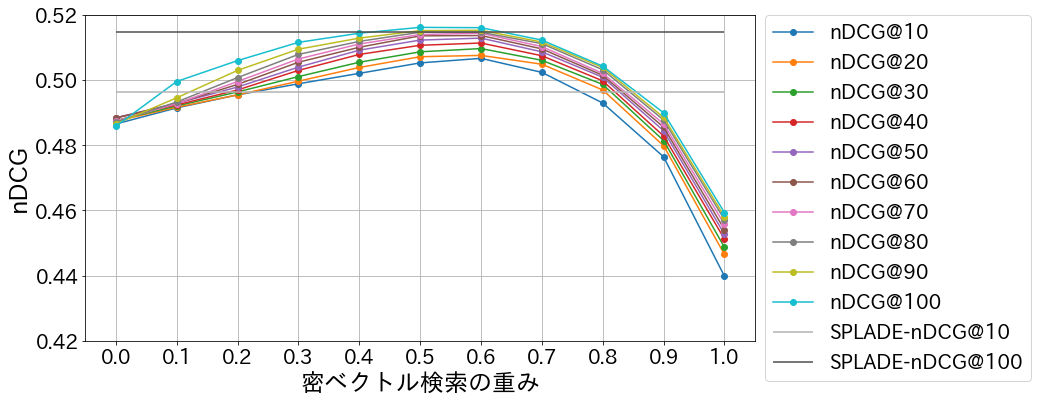

In [99]:
df_weight_cbm25_dense_ndcg = pd.DataFrame(all_weight_cbm25_dense_ndcg)
df_weight_cbm25_dense_ndcg.iloc[-1,:] = average_each_result_on_each_rank(cbm25_ndcg)
df_weight_cbm25_dense_ndcg.iloc[0,:] = average_each_result_on_each_rank(dense_ndcg)
df_weight_cbm25_dense_ndcg = df_weight_cbm25_dense_ndcg.iloc[:, 1:]
df_weight_cbm25_dense_ndcg.index = 1 - df_weight_cbm25_dense_ndcg.index
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel("密ベクトル検索の重み", fontsize=24)
ax1.set_ylabel("nDCG", fontsize=24)
ax1.tick_params(axis="x", labelsize=20)
ax1.tick_params(axis="y", labelsize=20)
for label, result in df_weight_cbm25_dense_ndcg.items():
    ax1.plot(result, marker="o", label=label.replace("NDCG", "nDCG"))

for i, (label, result) in enumerate(df_splade.items()):
    if label == "NDCG@10":
        ax1.hlines(result, 0.0, 1.0, colors="0.7", label=f"SPLADE-{label}".replace("NDCG", "nDCG"))
    if label == "NDCG@100":
        ax1.hlines(result, 0.0, 1.0, colors="0.3", label=f"SPLADE-{label}".replace("NDCG", "nDCG"))
ax1.set_xticks(np.arange(0, 1.1, 0.1))
# ax1.set_xlim(0, 1.1, 0.1)
ax1.set_ylim(0.43, 0.51)
ax1.set_yticks(np.arange(0.42, 0.52, 0.02))
ax1.grid()
# ax1.hlines(0.4784, -1, 20, label="全トークンの平均")
ax1.legend(fontsize=20, bbox_to_anchor=(1,1.03))
# df_weight_cbm25_dense_ndcg.iloc[:,1:].plot(ax=ax1, marker="o")
fig.savefig("fig_weight_cbm25_ndcg-deeper.svg", format="svg")
fig.savefig("fig_weight_cbm25_ndcg-deeper.png", format="png")

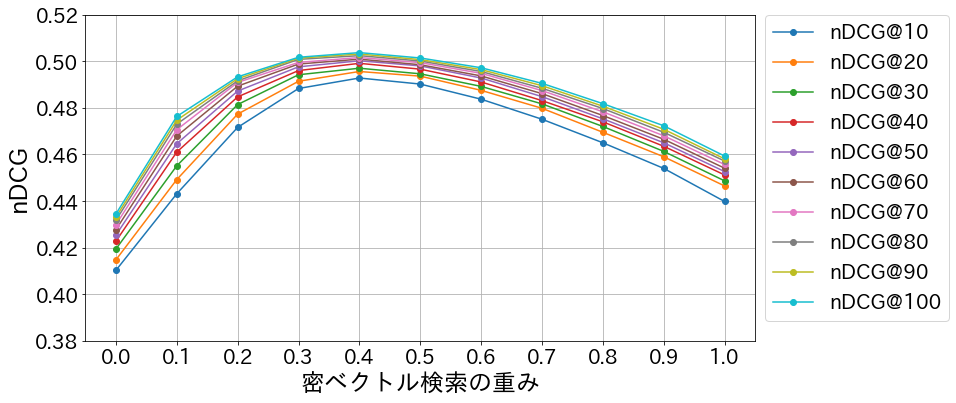

In [98]:
df_weight_bm25_dense_ndcg = pd.DataFrame(all_weight_bm25_dense_ndcg)
df_weight_bm25_dense_ndcg.iloc[-1,:] = average_each_result_on_each_rank(bm25_ndcg)
df_weight_bm25_dense_ndcg.iloc[0,:] = average_each_result_on_each_rank(dense_ndcg)
df_weight_bm25_dense_ndcg.index = 1 - df_weight_bm25_dense_ndcg.index
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel("密ベクトル検索の重み", fontsize=24)
ax1.set_ylabel("nDCG", fontsize=24)
ax1.tick_params(axis="x", labelsize=20)
ax1.tick_params(axis="y", labelsize=20)
for label, result in df_weight_bm25_dense_ndcg.items():
    if label == "NDCG@1":
        continue
    ax1.plot(result, marker="o", label=label.replace("NDCG", "nDCG"))
ax1.set_xticks(np.arange(0, 1.1, 0.1))
# ax1.set_xlim(0, 1, 0.1)
ax1.set_ylim(0.38, 0.52)
ax1.set_yticks(np.arange(0.38, 0.52, 0.02))
ax1.grid()
# ax1.hlines(0.4784, -1, 20, label="全トークンの平均")
ax1.legend(fontsize=20, bbox_to_anchor=(1, 1.03))
fig.savefig("fig_weight_bm25_ndcg-deeper.svg", format="svg")
fig.savefig("fig_weight_bm25_ndcg-deeper.png", format="png")
# df_weight_bm25_dense_ndcg.iloc[:, 1:].plot(ax=ax1, marker="o")
# fig.savefig("fig_window_ndcg.png", format="png")

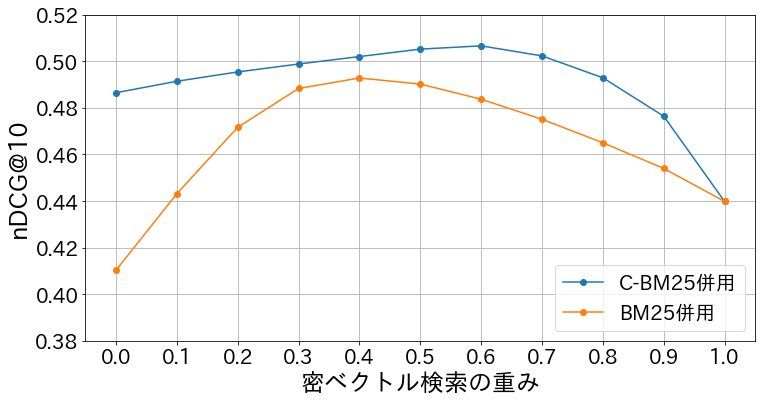

In [97]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel("密ベクトル検索の重み", fontsize=24)
ax1.set_ylabel("nDCG@10", fontsize=24)
ax1.tick_params(axis="x", labelsize=20)
ax1.tick_params(axis="y", labelsize=20)
ax1.plot(df_weight_cbm25_dense_ndcg["NDCG@10"], marker="o", label="C-BM25併用")
ax1.plot(df_weight_bm25_dense_ndcg["NDCG@10"], marker="o", label="BM25併用")
ax1.set_xticks(np.arange(0, 1.1, 0.1))
# ax1.set_xlim(0, 1, 0.1)
ax1.set_ylim(0.38, 0.52)
ax1.set_yticks(np.arange(0.38, 0.52, 0.02))
ax1.grid()
# ax1.hlines(0.4784, -1, 20, label="全トークンの平均")
ax1.legend(fontsize=20)
# df_weight_bm25_dense_ndcg.iloc[:, 1:].plot(ax=ax1, marker="o")
fig.savefig("fig_weight_ndcg10.svg", format="svg")
fig.savefig("fig_weight_ndcg10.png", format="png")

In [60]:
diff_cbm25 = defaultdict(dict)
diff_dense = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
    for qid in qrels:
        cbm25_sorted = sorted(cbm25_result[qid].values(), key=lambda x: -x)
        dense_sorted = sorted(dense_result[qid].values(), key=lambda x: -x)
        if len(cbm25_sorted) >= 100:
            diff_cbm25[dataset][qid] = cbm25_sorted[0] - cbm25_sorted[99]
        elif cbm25_sorted:
            diff_cbm25[dataset][qid] = cbm25_sorted[0] - cbm25_sorted[-1]
        if len(cbm25_sorted) >= 100:
            diff_dense[dataset][qid] = dense_sorted[0] - dense_sorted[99]
        elif cbm25_sorted:
            diff_dense[dataset][qid] = dense_sorted[0] - dense_sorted[-1]
        

  0%|          | 0/16 [00:00<?, ?it/s]

In [78]:
diff_bm25 = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, bm25_result, dense_result = load_dataset_and_bm25_dense_result(dataset, data_dir_root, result_dir_root)
    for qid in qrels:
        try:
            bm25_sorted = sorted(bm25_result[qid].values(), key=lambda x: -x)
        except KeyError:
            continue
        if len(bm25_sorted) >= 100:
            diff_bm25[dataset][qid] = bm25_sorted[0] - bm25_sorted[99]
        elif bm25_sorted:
            diff_bm25[dataset][qid] = bm25_sorted[0] - bm25_sorted[-1]

  0%|          | 0/16 [00:00<?, ?it/s]

In [70]:
diff_cbm25_10 = defaultdict(dict)
diff_dense_10 = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
    for qid in qrels:
        cbm25_sorted = sorted(cbm25_result[qid].values(), key=lambda x: -x)
        dense_sorted = sorted(dense_result[qid].values(), key=lambda x: -x)
        if len(cbm25_sorted) >= 10:
            diff_cbm25_10[dataset][qid] = cbm25_sorted[0] - cbm25_sorted[9]
        elif cbm25_sorted:
            diff_cbm25_10[dataset][qid] = cbm25_sorted[0] - cbm25_sorted[-1]
        if len(dense_sorted) >= 10:
            diff_dense_10[dataset][qid] = dense_sorted[0] - dense_sorted[9]
        elif dense_sorted:
            diff_dense_10[dataset][qid] = dense_sorted[0] - dense_sorted[-1]

  0%|          | 0/16 [00:00<?, ?it/s]

In [79]:
diff_cbm25_per_dataset = defaultdict(float)
for dataset, diffs in diff_cbm25.items():
    diff_cbm25_per_dataset[dataset] = np.mean(list(diffs.values()))

diff_dense_per_dataset = defaultdict(float)
for dataset, diffs in diff_dense.items():
    diff_dense_per_dataset[dataset] = np.mean(list(diffs.values()))

diff_bm25_per_dataset = defaultdict(float)
for dataset, diffs in diff_bm25.items():
    diff_bm25_per_dataset[dataset] = np.mean(list(diffs.values()))
    

pprint(diff_cbm25_per_dataset)
pprint(diff_dense_per_dataset)
pprint(diff_bm25_per_dataset)


pprint(np.mean(list(diff_cbm25_per_dataset.values())))
pprint(np.mean(list(diff_dense_per_dataset.values())))
pprint(np.mean(list(diff_bm25_per_dataset.values())))


defaultdict(<class 'float'>,
            {'arguana': 171.4682025358501,
             'climate-fever': 22.460965347083516,
             'dbpedia-entity': 13.305862211168792,
             'fever': 22.491315976659283,
             'fiqa': 14.10870950680447,
             'hotpotqa': 27.988628344008802,
             'msmarco': 20.212367849021412,
             'nfcorpus': 8.242291702144124,
             'nq': 18.493325462359063,
             'quora': 31.774617332405782,
             'scidocs': 16.91188220436946,
             'scifact': 26.875023632855903,
             'trec-covid': 16.026236881917722,
             'trec-robust04-desc': 17.234238717859103,
             'trec-robust04-title': 11.508441884423563,
             'webis-touche2020': 18.262194157961915})
defaultdict(<class 'float'>,
            {'arguana': 12.483871803175164,
             'climate-fever': 6.052228881015839,
             'dbpedia-entity': 7.892537624835968,
             'fever': 8.36871487723075,
             'fiqa':

# Simcse

In [ ]:
def load_dataset_and_simcse_bm25_dense_result(dataset, data_dir_root, result_dir_root):
    data_dir = os.path.join(data_dir_root, dataset)
    queries, qrels = QrelDataLoader(data_folder=data_dir).load(split="test")
    
    bm25_result_path = os.path.join(result_dir_root, dataset, "result/bm25/analysis.json")
    dense_result_path = os.path.join(result_dir_root, dataset, "result/cos_sim/simcse/analysis.json")

    with open(bm25_result_path) as f:
        bm25_result = json.load(f)
    
    with open(dense_result_path) as f:
         dense_result = json.load(f)
            
    all_qids = qrels.keys()
    return (all_qids, qrels, bm25_result, dense_result)

In [ ]:
def load_dataset_and_simcse_cbm25_dense_result(dataset, data_dir_root, result_dir_root):
    data_dir = os.path.join(data_dir_root, dataset)
    queries, qrels = QrelDataLoader(data_folder=data_dir).load(split="test")
    cbm25_result_path = os.path.join(result_dir_root, dataset, "result/lss/simcse/analysis.json")
    dense_result_path = os.path.join(result_dir_root, dataset, "result/cos_sim/simcse/analysis.json")

    with open(cbm25_result_path) as f:
        cbm25_result = list(json.load(f).values())[0]
    
    with open(dense_result_path) as f:
        dense_result = json.load(f)
            
    all_qids = qrels.keys()
    return (all_qids, qrels, cbm25_result, dense_result)

In [18]:
weight_simcse_bm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, bm25_result, dense_result = load_dataset_and_simcse_bm25_dense_result(dataset, data_dir_root, result_dir_root)
    weight = 0.5
    ndcg10 = weight_add_result_per_dataset(weight, all_qids, qrels, bm25_result, dense_result)
    weight_simcse_bm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10


  0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
weight_simcse_bm25_dense_ndcg

defaultdict(dict,
            {0.5: {'arguana': 0.36527,
              'climate-fever': 0.16358,
              'dbpedia-entity': 0.29008,
              'fever': 0.58445,
              'fiqa': 0.23681,
              'hotpotqa': 0.57229,
              'msmarco': 0.51167,
              'nfcorpus': 0.30174,
              'nq': 0.25095,
              'quora': 0.80461,
              'scidocs': 0.14061,
              'scifact': 0.66441,
              'trec-covid': 0.53538,
              'trec-robust04-title': 0.45282,
              'trec-robust04-desc': 0.41573,
              'webis-touche2020': 0.4627}})

In [21]:
weight_simcse_cbm25_dense_ndcg = defaultdict(dict)
for dataset in tqdm(datasets):
    all_qids, qrels, cbm25_result, dense_result = load_dataset_and_simcse_cbm25_dense_result(dataset, data_dir_root, result_dir_root)
    weight = 0.5
    ndcg10 = weight_add_result_per_dataset(weight, all_qids, qrels, cbm25_result, dense_result)
    weight_simcse_cbm25_dense_ndcg[round(weight, 2)][dataset] = ndcg10


  0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
weight_simcse_cbm25_dense_ndcg

defaultdict(dict,
            {0.5: {'arguana': 0.46527,
              'climate-fever': 0.19916,
              'dbpedia-entity': 0.32758,
              'fever': 0.6653,
              'fiqa': 0.27699,
              'hotpotqa': 0.64212,
              'msmarco': 0.52741,
              'nfcorpus': 0.31746,
              'nq': 0.3378,
              'quora': 0.82081,
              'scidocs': 0.15574,
              'scifact': 0.69569,
              'trec-covid': 0.67654,
              'trec-robust04-title': 0.44068,
              'trec-robust04-desc': 0.44887,
              'webis-touche2020': 0.37021}})

# Test

In [3]:
k_values=[1,10,100]
test_qrel = {
    'q1': {
        'd1': 0,
        'd2': 1,
        'd3': 0,
    },
    'q2': {
        'd2': 1,
        'd3': 1,
    },
}

test_run = {
    'q1': {
        'd1': 1.0,
        'd2': 0.1,
        'd3': 1.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
    }
}

test_run2 = {
    'q1': {
        'd1': 1.0,
        'd2': 0.2,
        'd3': 1.5,
        'd4': 0.4,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
        'd4': 0.01,       
    }
}

ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run, k_values=k_values)
ndcg

{'NDCG@1': 0.0, 'NDCG@10': 0.59671, 'NDCG@100': 0.59671}

In [4]:
ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run2, k_values=k_values)
ndcg

{'NDCG@1': 0.0, 'NDCG@10': 0.56205, 'NDCG@100': 0.56205}

In [5]:
test_run3 = {
    'q1': {
        'd1': 1.0,
        'd2': 0.2,
        'd3': 1.5,
        'd4': 0.4,
        "d5": 0.5,
        "d6": 0.6,
        "d7": 0.7,
        "d8": 0.8,
        "d9": 0.9,
        "d10": 0.95,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
        'd4': 0.01,
        "d5": 0.02,
        "d6": 0.03,
        "d7": 0.04,
        "d8": 0.05,
        "d9": 0.06,
        "d10": 0.07,
    }
}

test_run4 = {
    'q1': {
        'd1': 1.0,
        'd2': 0.2,
        'd3': 1.5,
        'd4': 0.4,
        "d5": 0.5,
        "d6": 0.6,
        "d7": 0.7,
        "d8": 0.8,
        "d9": 0.9,
        "d10": 0.95,
        "d11": 0.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
        'd4': 0.01,
        "d5": 0.02,
        "d6": 0.03,
        "d7": 0.04,
        "d8": 0.05,
        "d9": 0.06,
        "d10": 0.07,
        "d11": 0.05,
        
    }
}

ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run3, k_values=k_values)
ndcg

{'NDCG@1': 0.0, 'NDCG@10': 0.49125, 'NDCG@100': 0.49125}

In [6]:
ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run4, k_values=k_values)
ndcg

{'NDCG@1': 0.0, 'NDCG@10': 0.34671, 'NDCG@100': 0.48618}

In [7]:
test_qrel = {
    'q1': {
        'd1': 0,
        'd2': 1,
        'd3': 0,
    },
    'q2': {
        'd2': 1,
        'd3': 1,
    },
    "q3":{
        "d4": 1,
    }
}

test_run = {
    'q1': {
        'd1': 1.0,
        'd2': 0.1,
        'd3': 1.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
    }
}

test_run2 = {
    'q1': {
        'd1': 1.0,
        'd2': 0.2,
        'd3': 1.5,
        'd4': 0.4,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
        'd4': 0.01,       
    },
    "q3": {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
        'd4': 0.01, 
    }
}

ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run, k_values=k_values)
print(ndcg)

ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run2, k_values=k_values)
print(ndcg)

    
test_run5 = weight_add_result(test_run, test_run2, {"q1", "q2", "q3"}, 1.0)
print(test_run5)
ndcg, map_, recall, p = EvaluateRetrieval("").evaluate(test_qrel, test_run5, k_values=k_values)
ndcg

{'NDCG@1': 0.0, 'NDCG@10': 0.59671, 'NDCG@100': 0.59671}
{'NDCG@1': 0.0, 'NDCG@10': 0.51826, 'NDCG@100': 0.51826}
{'q1': {'d4': 0.099, 'd3': 1.5, 'd1': 1.0, 'd2': 0.1}, 'q2': {'d4': 0.199, 'd3': 0.5, 'd1': 1.5, 'd2': 0.2}}


{'NDCG@1': 0.0, 'NDCG@10': 0.59671, 'NDCG@100': 0.59671}

In [6]:
from sklearn.metrics import ndcg_score

In [26]:
y_true1 =  [[1,1,0,0,0,0,0,0,0,0],[0,1,1,0,0,0,0,0,0,0]]
y_true2 = [[1,1,0,0,0,0,0,0,0,0,0],[0,1,1,0,0,0,0,0,0,0,0]]

run1 = [[1.0, 0.0, 1.5],[1.5, 0.2, 0.5]]
run2 = [[1.0, 0.1, 1.5, 0.0],[1.5, 0.2, 0.5, 0.19]]

print(ndcg_score(y_true1, run1))
print(ndcg_score(y_true2, run2))

        

0.5967132018086354
0.5967132018086354
